In [ ]:
### load libraries and settings

In [1]:
# General Purpose

from scipy.integrate import odeint, solve_ivp

# Jupyter Specifics
from IPython.display import HTML
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout

%matplotlib inline

style = {'description_width': '150px'}
slider_layout = Layout(width='99%')


import pandas as pd
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import os
from pyDOE import lhs
import timeit

warnings.filterwarnings('once')
sns.set(style = 'white', context = 'notebook', font = 'Arial', palette = 'Set2')

folder_base ='\\'
folder_fig = folder_base + 'figures_all\\'
folder_data = folder_base + 'data\\'

In [ ]:
## define function for simulation

In [126]:
def main(
         decay_PKAa, km_PKAa, hill_PKAa, beta_PKAa, basal_PKAa, betaI_PKAa, hillI_PKAa, kmI_PKAa, 
         decay_p38a, km_p38a, hill_p38a, beta_p38a, basal_p38a, betaI_p38a, hillI_p38a, kmI_p38a,
         decay_ERKa, km_ERKa, hill_ERKa, beta_ERKa, basal_ERKa, betaI_ERKa, hillI_ERKa, kmI_ERKa,):

    def function(t, s):
        PKAa, PKAi, p38a, p38i, ERKa, ERKi = s
        dydt = [
            PKAi * (basal_PKAa +(beta_PKAa * cAMP**hill_PKAa/(cAMP**hill_PKAa + km_PKAa**hill_PKAa)))
                                 - PKAa * (decay_PKAa + betaI_p38a * p38a**hillI_p38a / ( p38a**hillI_p38a + kmI_p38a**hillI_p38a) + betaI_ERKa * ERKa**hillI_ERKa / ( ERKa**hillI_ERKa + kmI_ERKa**hillI_ERKa)) , # dPKAa/dt: Change in PKAa
            
            PKAa * (decay_PKAa + betaI_p38a * p38a**hillI_p38a / ( p38a**hillI_p38a + kmI_p38a**hillI_p38a) + betaI_ERKa * ERKa**hillI_ERKa / ( ERKa**hillI_ERKa + kmI_ERKa**hillI_ERKa))
                                 - PKAi * (basal_PKAa +(beta_PKAa * cAMP**hill_PKAa/(cAMP**hill_PKAa + km_PKAa**hill_PKAa))) ,      # dPKAi/dt: Change in PKAi
            
            p38i * (basal_p38a +(beta_p38a * cAMP**hill_p38a/(cAMP**hill_p38a + km_p38a**hill_p38a)))
                                 - decay_p38a * p38a, # dp38a/dt: Change in PKAa
            
            decay_p38a * p38a
                                 - p38i * (basal_p38a +(beta_p38a * cAMP**hill_p38a/(cAMP**hill_p38a + km_p38a**hill_p38a))),     # dp38i/dt: Change in PKAi
            
            ERKi * (basal_ERKa +(beta_ERKa * cAMP**hill_ERKa/(cAMP**hill_ERKa + km_ERKa**hill_ERKa)))
                                 - ERKa * (decay_ERKa + betaI_PKAa * PKAa**hillI_PKAa / ( PKAa**hillI_PKAa + kmI_PKAa**hillI_PKAa) ), # dERKa/dt: Change in PKAa
            
            ERKa * (decay_ERKa + betaI_PKAa * PKAa**hillI_PKAa / ( PKAa**hillI_PKAa + kmI_PKAa**hillI_PKAa) )
                                 - ERKi * (basal_ERKa +(beta_ERKa * cAMP**hill_ERKa/(cAMP**hill_ERKa + km_ERKa**hill_ERKa)))]    # ERKi/dt: Change in PKAi

        return dydt
#     concentrations = np.arange(0, 1.1, 0.25) # run ODE at 5 cAMP concentrations
    concentrations = [0, 0.003, 0.017, 0.033, 0.067, 0.333, 1]
    concentrations = np.arange(0,1,0.001)
    minutes = 50 # always 20 min
    initial_PKAa = 0
    initial_p38a = 0
    initial_ERKa = 0
    initial_PKAi = 1
    initial_p38i = 1
    initial_ERKi = 1
    
    time = np.arange(0, minutes, 1)
    initial_conditions = [initial_PKAa, initial_PKAi, initial_p38a, initial_p38i, initial_ERKa, initial_ERKi]
    
    
    
    y1 = np.empty(len(concentrations))
    y2 = np.empty(len(concentrations))
    y3 = np.empty(len(concentrations))
    y4 = np.empty(len(concentrations))
    y5 = np.empty(len(concentrations))
    y6 = np.empty(len(concentrations))
    
    aa=0
    for cAMP in concentrations:
        solution = solve_ivp(function, [time[0], time[-1]], initial_conditions)
        y1[aa] = solution.y[0][-1] #pkaa
        y2[aa] = solution.y[1][-1] #pkai
        y3[aa] = solution.y[2][-1] #p38a
        y4[aa] = solution.y[3][-1] #p38i
        y5[aa] = solution.y[4][-1] #ERKa
        y6[aa] = solution.y[5][-1] #ERKi
        aa=aa+1
    return y1, y3, y5


In [ ]:
### setup parameters

In [262]:
sample = lhs(24, samples = 10000)
sample[:,[0,8, 16]] = sample[:,[0,8, 16]] * (1 - 0.01) + 0.01 #DECAYS
sample[:,[1,9, 17,7,15,23]] = sample[:,[1,9, 17,7,15,23]] * (1 - 0.01) + 0.01 #KM
sample[:,[2,10, 18, 6, 14,22]] = sample[:,[2,10, 18, 6, 14,22]] * (10 - 1) + 1 #HILL
sample[:,[3,11, 19, 5, 13, 21]] = sample[:,[3,11, 19, 5, 13, 21]] * (10 - 0.1) + 0.1 #beta
sample[:,[4,12, 20]] = sample[:,[4,12, 20]] * (1 - 0.01) + 0.01 #BASAL

# sample

In [ ]:
###run simulations

In [263]:
start = timeit.default_timer()

parameters_dmso = np.array(sample)
parameters_p38i = np.array(sample)
parameters_ERKi = np.array(sample)
parameters_p38i[:,13] = 0
parameters_ERKi[:,[19, 20]] = 0



iterations = np.arange(len(sample))

f1 = np.empty((len(sample),7))# dmso
f3 = np.empty((len(sample),7))
f5 = np.empty((len(sample),7))


ff1 = np.empty((len(sample),7)) #p38 inhibition
ff3 = np.empty((len(sample),7))
ff5 = np.empty((len(sample),7))


fff1 = np.empty((len(sample),7)) # ERK inhibition
fff3 = np.empty((len(sample),7))
fff5 = np.empty((len(sample),7))

for ii in iterations:
    y1, y3, y5 = main(*parameters_dmso[ii])
    f1[ii] = y1
    f3[ii] = y3
    f5[ii] = y5
    
    y1, y3, y5 = main(*parameters_p38i[ii])
    ff1[ii] = y1
    ff3[ii] = y3
    ff5[ii] = y5
    
    y1, y3, y5 = main(*parameters_ERKi[ii])
    fff1[ii] = y1
    fff3[ii] = y3
    fff5[ii] = y5



np.savetxt("d:\PKAa_ODEsim_DMSO_dutycycle.csv", f1, delimiter=",")
np.savetxt("d:\p38a_ODEsim_DMSO_dutycycle.csv", f3, delimiter=",")
np.savetxt("d:\ERKa_ODEsim_DMSO_dutycycle.csv", f5, delimiter=",")

np.savetxt("d:\PKAa_ODEsim_p38i_dutycycle.csv", ff1, delimiter=",")
np.savetxt("d:\p38a_ODEsim_p38i_dutycycle.csv", ff3, delimiter=",")
np.savetxt("d:\ERKa_ODEsim_p38i_dutycycle.csv", ff5, delimiter=",")

np.savetxt("d:\PKAa_ODEsim_ERKi_dutycycle.csv", fff1, delimiter=",")
np.savetxt("d:\p38a_ODEsim_ERKi_dutycycle.csv", fff3, delimiter=",")
np.savetxt("d:\ERKa_ODEsim_ERKi_dutycycle.csv", fff5, delimiter=",")


np.savetxt("d:\parameters_ODEsim_DMSO_run_dutycycle.csv", parameters_dmso, delimiter=",")
np.savetxt("d:\parameters_ODEsim_p38i_run_dutycycle.csv", parameters_p38i, delimiter=",")
np.savetxt("d:\parameters_ODEsim_ERKi_run_dutycycle.csv", parameters_ERKi, delimiter=",")



stop = timeit.default_timer()
print('Time: ', stop - start)

<input>:45: DeprecationWarning: invalid escape sequence \P
<input>:46: DeprecationWarning: invalid escape sequence \p
<input>:47: DeprecationWarning: invalid escape sequence \E
<ipython-input-263-a4c5a95d59f3>:45: DeprecationWarning: invalid escape sequence \P
  np.savetxt("d:\PKAa_ODEsim_DMSO_dutycycle.csv", f1, delimiter=",")
<ipython-input-263-a4c5a95d59f3>:46: DeprecationWarning: invalid escape sequence \p
  np.savetxt("d:\p38a_ODEsim_DMSO_dutycycle.csv", f3, delimiter=",")
<ipython-input-263-a4c5a95d59f3>:47: DeprecationWarning: invalid escape sequence \E
  np.savetxt("d:\ERKa_ODEsim_DMSO_dutycycle.csv", f5, delimiter=",")
c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\scipy\integrate\_ivp\rk.py:144: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.a

Time:  8807.272856404452


In [8]:
## load runs if necessary

parameters_dmso = np.genfromtxt("d:\parameters_ODEsim_DMSO_run_dutycycle.csv", delimiter=',')

f1 = np.genfromtxt("d:\PKAa_ODEsim_DMSO_dutycycle.csv", delimiter=',')
f3 = np.genfromtxt("d:\p38a_ODEsim_DMSO_dutycycle.csv", delimiter=',')
f5 = np.genfromtxt("d:\ERKa_ODEsim_DMSO_dutycycle.csv", delimiter=',')

ff1 = np.genfromtxt("d:\PKAa_ODEsim_p38i_dutycycle.csv", delimiter=',')
ff3 = np.genfromtxt("d:\p38a_ODEsim_p38i_dutycycle.csv", delimiter=',')
ff5 = np.genfromtxt("d:\ERKa_ODEsim_p38i_dutycycle.csv", delimiter=',')

fff1 = np.genfromtxt("d:\PKAa_ODEsim_ERKi_dutycycle.csv", delimiter=',')
fff3 = np.genfromtxt("d:\p38a_ODEsim_ERKi_dutycycle.csv", delimiter=',')
fff5 = np.genfromtxt("d:\ERKa_ODEsim_ERKi_dutycycle.csv", delimiter=',')

<input>:3: DeprecationWarning: invalid escape sequence \p
<input>:5: DeprecationWarning: invalid escape sequence \P
<input>:7: DeprecationWarning: invalid escape sequence \E
<ipython-input-8-3187bed3d328>:3: DeprecationWarning: invalid escape sequence \p
  parameters_dmso = np.genfromtxt("d:\parameters_ODEsim_DMSO_run_dutycycle.csv", delimiter=',')
<ipython-input-8-3187bed3d328>:5: DeprecationWarning: invalid escape sequence \P
  f1 = np.genfromtxt("d:\PKAa_ODEsim_DMSO_dutycycle.csv", delimiter=',')
<ipython-input-8-3187bed3d328>:7: DeprecationWarning: invalid escape sequence \E
  f5 = np.genfromtxt("d:\ERKa_ODEsim_DMSO_dutycycle.csv", delimiter=',')


In [37]:
## plot example

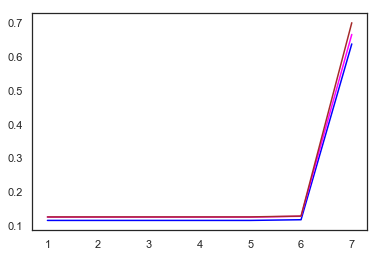

In [10]:
# cAMP = np.arange(0, 1.1, 0.25)
cAMP = [0, 0.003, 0.017, 0.033, 0.067, 0.333, 1]
cAMP = np.arange(1,8)

for ii in np.arange(5,6):
    plt.plot(cAMP, f1[ii], color='blue')
    plt.plot(cAMP, ff1[ii], color='magenta')
    plt.plot(cAMP, fff1[ii], color='brown')

In [115]:


### find examples with defined behaviors

In [11]:
filterset = (
    ((fff1[:,6]/f1[:,6] > fff1[:,0]/f1[:,0])  & (fff1[:,5]/f1[:,5] > fff1[:,0]/f1[:,0]) ) & #ERK inhibition should be stronger at larger cAMP
       ((ff1[:,0] >f1[:,0]) & (ff1[:,1] >f1[:,1]) & (ff1[:,2] >f1[:,2])& (ff1[:,3] >f1[:,3])& (ff1[:,4] >f1[:,4]) & (ff1[:,5] >f1[:,5]) & (ff1[:,6] >f1[:,6])) &  #p38 inhibition increases PKA all over cAMP doses
       ((f3[:,2] <f3[:,3])& (f3[:,3] <f3[:,4])& (f3[:,4] <f3[:,5])& (f3[:,5] <f3[:,6]))&  #p38 is activated by cAMP
       ((np.max(f1, axis = 1)> f1[:,0]*1.05) ) * #PKA is activated in middle of cAMP
       ((np.min(f5, axis = 1)*1.05< f5[:,0]) ) &#ERK is inhibited in middle of cAMP
((f1[:,0] > f1[:,6]*1.05) & (f1[:,0] > f1[:,5]))  &   #  PKA is inhibited by  high cAMP
((f5[:,0]*1.05 < f5[:,6]) & ((f5[:,0] < f5[:,5])))     #  ERK is Activated by  high cAMP
)
print( sum(filterset==True))


25


In [12]:
f1_filter = f1[filterset,:]
ff1_filter = ff1[filterset,:]
fff1_filter = fff1[filterset,:]

f5_filter = f5[filterset,:]

parameters_dmso_filter = parameters_dmso[filterset,:]

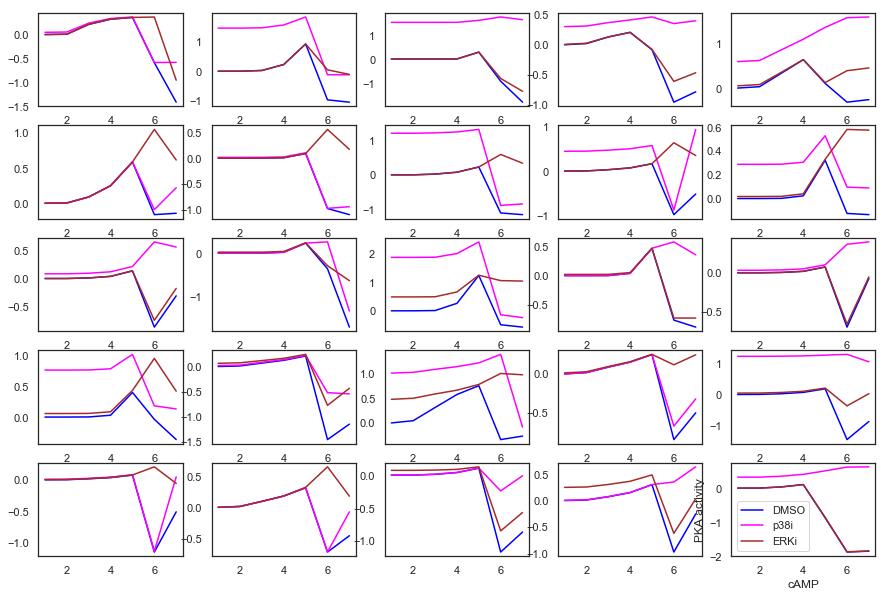

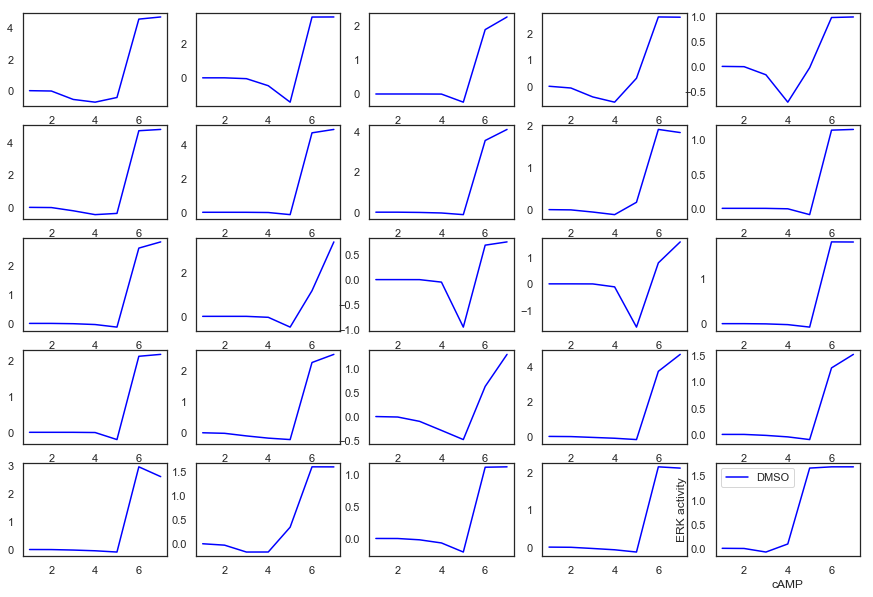

In [24]:


fig,axes = plt.subplots(5,2, figsize= (15,10))

for ii in np.arange(0, 25):
    plt.subplot(5,5,ii+1)
    plt.plot(cAMP, np.log2(f1_filter[ii] / f1_filter[ii][0]) , color='blue', label = 'DMSO')
    plt.plot(cAMP, np.log2(ff1_filter[ii] / f1_filter[ii][0]), color='magenta', label = 'p38i')
    plt.plot(cAMP, np.log2(fff1_filter[ii]/ f1_filter[ii][0]), color='brown', label = 'ERKi')

plt.ylabel('PKA activity')
plt.xlabel('cAMP')   
plt.legend()
plt.show()

fig,axes = plt.subplots(5,2, figsize= (15,10))
for ii in np.arange(0, 25):
    plt.subplot(5,5,ii+1)
    plt.plot(cAMP, np.log2(f5_filter[ii]/f5_filter[ii][0]), color='blue', label = 'DMSO')
#     plt.plot(cAMP, ff1_filter[ii], color='magenta', label = 'p38i')
#     plt.plot(cAMP, fff1_filter[ii], color='brown', label = 'ERKi')

plt.ylabel('ERK activity')
plt.xlabel('cAMP')   
plt.legend()
plt.show()

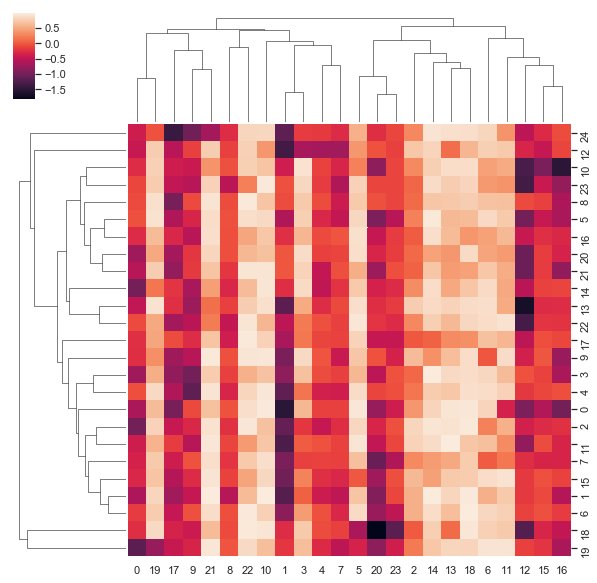

In [22]:
sns.clustermap(np.log10(parameters_dmso_filter), col_cluster=True, metric = 'correlation')

# sns.pairplot(pd.DataFrame(parameters_dmso_filter[:,np.concatenate((np.arange(5,8), np.arange(13, 16), np.arange(21, 24)), axis = 0)]), kind = 'reg')



In [43]:
np.round(parameters_dmso_filter_opt[bb,:], decimals = 2)

array([1.  , 0.02, 0.87, 1.94, 1.23, 1.73, 5.91, 0.57, 3.4 , 0.54, 1.3 ,
       8.75, 0.47, 8.18, 1.48, 0.87, 0.36, 0.65, 1.14, 5.88, 0.79, 9.02,
       5.37, 1.04])

In [3]:
## optimization

#x
dutycycle = [0, 0.003, 0.017, 0.033, 0.067, 0.333, 1]

#ydata
PKA_DMSO_data = [0, 0.280, 0.510, 0.453, 0.421, -0.101, -0.633]
PKA_SB202_data = [0.456, 0.469, 0.790, 0.754, 1.00, 0.716, 0.312]
PKA_U0_data = [0.049, 0.306, 0.380,0.695, 0.679, 0.1578, 0.128]
p38_DMSO_data = [0, -0.016, 0.108, 0.516, 0.985, 2.030, 2.464]
ERK_DMSO_data = [0, -0.499, -0.425, -.521, -0.104, 0.514, 0.528 ]

ydata = np.concatenate((PKA_DMSO_data, p38_DMSO_data, ERK_DMSO_data, PKA_SB202_data, PKA_U0_data))


#sigma
PKA_DMSO_sigma = [0.139, 0.187, 0.501, 0.339, 0.296, 0.596, 0.649]
ERK_DMSO_sigma = [0.229, 0.433, 0.391, 0.449, 0.316, 0.676, 0.379]
p38_DMSO_sigma = [0.001, 0.697, 0.631, 0.706, 1.324, 0.737, 0.830]
PKA_SB202_sigma = [0.237, 0.289, 0.774, 0.301, 0.569, 0.305, 0.348]
PKA_U0_sigma = [0.101, 0.303, 0.254, 0.307, 0.130, 0.098, 0.113]

sigma = np.concatenate((PKA_DMSO_sigma, p38_DMSO_sigma, ERK_DMSO_sigma, PKA_SB202_sigma, PKA_U0_sigma))


# define function
def fun(
         decay_PKAa, km_PKAa, hill_PKAa, beta_PKAa, basal_PKAa, betaI_PKAa, hillI_PKAa, kmI_PKAa, 
         decay_p38a, km_p38a, hill_p38a, beta_p38a, basal_p38a, betaI_p38a, hillI_p38a, kmI_p38a,
         decay_ERKa, km_ERKa, hill_ERKa, beta_ERKa, basal_ERKa, betaI_ERKa, hillI_ERKa, kmI_ERKa,):

    def function(t, s):
        PKAa, PKAi, p38a, p38i, ERKa, ERKi = s
        dydt = [
            PKAi * (basal_PKAa +(beta_PKAa * cAMP**hill_PKAa/(cAMP**hill_PKAa + km_PKAa**hill_PKAa)))
                                 - PKAa * (decay_PKAa + betaI_p38a * p38a**hillI_p38a / ( p38a**hillI_p38a + kmI_p38a**hillI_p38a) + betaI_ERKa * ERKa**hillI_ERKa / ( ERKa**hillI_ERKa + kmI_ERKa**hillI_ERKa)) , # dPKAa/dt: Change in PKAa
            
            PKAa * (decay_PKAa + betaI_p38a * p38a**hillI_p38a / ( p38a**hillI_p38a + kmI_p38a**hillI_p38a) + betaI_ERKa * ERKa**hillI_ERKa / ( ERKa**hillI_ERKa + kmI_ERKa**hillI_ERKa))
                                 - PKAi * (basal_PKAa +(beta_PKAa * cAMP**hill_PKAa/(cAMP**hill_PKAa + km_PKAa**hill_PKAa))) ,      # dPKAi/dt: Change in PKAi
            
            p38i * (basal_p38a +(beta_p38a * cAMP**hill_p38a/(cAMP**hill_p38a + km_p38a**hill_p38a)))
                                 - decay_p38a * p38a, # dp38a/dt: Change in PKAa
            
            decay_p38a * p38a
                                 - p38i * (basal_p38a +(beta_p38a * cAMP**hill_p38a/(cAMP**hill_p38a + km_p38a**hill_p38a))),     # dp38i/dt: Change in PKAi
            
            ERKi * (basal_ERKa +(beta_ERKa * cAMP**hill_ERKa/(cAMP**hill_ERKa + km_ERKa**hill_ERKa)))
                                 - ERKa * (decay_ERKa + betaI_PKAa * PKAa**hillI_PKAa / ( PKAa**hillI_PKAa + kmI_PKAa**hillI_PKAa) ), # dERKa/dt: Change in PKAa
            
            ERKa * (decay_ERKa + betaI_PKAa * PKAa**hillI_PKAa / ( PKAa**hillI_PKAa + kmI_PKAa**hillI_PKAa) )
                                 - ERKi * (basal_ERKa +(beta_ERKa * cAMP**hill_ERKa/(cAMP**hill_ERKa + km_ERKa**hill_ERKa)))]    # ERKi/dt: Change in PKAi

        return dydt
    concentrations = [0, 0.003, 0.017, 0.033, 0.067, 0.333, 1]
#     concentrations = np.arange(0,1,0.001) 
    minutes = 50 # always 20 min
    initial_PKAa = 0
    initial_p38a = 0
    initial_ERKa = 0
    initial_PKAi = 1
    initial_p38i = 1
    initial_ERKi = 1
    
    time = np.arange(0, minutes, 1)
    initial_conditions = [initial_PKAa, initial_PKAi, initial_p38a, initial_p38i, initial_ERKa, initial_ERKi]
    
    
    
    y1 = np.empty(len(concentrations))
    y2 = np.empty(len(concentrations))
    y3 = np.empty(len(concentrations))
    y4 = np.empty(len(concentrations))
    y5 = np.empty(len(concentrations))
    y6 = np.empty(len(concentrations))
    
    aa=0
    for cAMP in concentrations:
        solution = solve_ivp(function, [time[0], time[-1]], initial_conditions)
        y1[aa] = solution.y[0][-1] #pkaa
        y2[aa] = solution.y[1][-1] #pkai
        y3[aa] = solution.y[2][-1] #p38a
        y4[aa] = solution.y[3][-1] #p38i
        y5[aa] = solution.y[4][-1] #ERKa
        y6[aa] = solution.y[5][-1] #ERKi
        aa=aa+1
    
    return y1, y3, y5



def fun2(
         decay_PKAa, km_PKAa, hill_PKAa, beta_PKAa, basal_PKAa, betaI_PKAa, hillI_PKAa, kmI_PKAa, 
         decay_p38a, km_p38a, hill_p38a, beta_p38a, basal_p38a, betaI_p38a, hillI_p38a, kmI_p38a,
         decay_ERKa, km_ERKa, hill_ERKa, beta_ERKa, basal_ERKa, betaI_ERKa, hillI_ERKa, kmI_ERKa,):

    def function(t, s):
        PKAa, PKAi, p38a, p38i, ERKa, ERKi = s
        dydt = [
            PKAi * (basal_PKAa +(beta_PKAa * cAMP**hill_PKAa/(cAMP**hill_PKAa + km_PKAa**hill_PKAa)))
                                 - PKAa * (decay_PKAa + betaI_p38a * p38a**hillI_p38a / ( p38a**hillI_p38a + kmI_p38a**hillI_p38a) + betaI_ERKa * ERKa**hillI_ERKa / ( ERKa**hillI_ERKa + kmI_ERKa**hillI_ERKa)) , # dPKAa/dt: Change in PKAa
            
            PKAa * (decay_PKAa + betaI_p38a * p38a**hillI_p38a / ( p38a**hillI_p38a + kmI_p38a**hillI_p38a) + betaI_ERKa * ERKa**hillI_ERKa / ( ERKa**hillI_ERKa + kmI_ERKa**hillI_ERKa))
                                 - PKAi * (basal_PKAa +(beta_PKAa * cAMP**hill_PKAa/(cAMP**hill_PKAa + km_PKAa**hill_PKAa))) ,      # dPKAi/dt: Change in PKAi
            
            p38i * (basal_p38a +(beta_p38a * cAMP**hill_p38a/(cAMP**hill_p38a + km_p38a**hill_p38a)))
                                 - decay_p38a * p38a, # dp38a/dt: Change in PKAa
            
            decay_p38a * p38a
                                 - p38i * (basal_p38a +(beta_p38a * cAMP**hill_p38a/(cAMP**hill_p38a + km_p38a**hill_p38a))),     # dp38i/dt: Change in PKAi
            
            ERKi * (basal_ERKa +(beta_ERKa * cAMP**hill_ERKa/(cAMP**hill_ERKa + km_ERKa**hill_ERKa)))
                                 - ERKa * (decay_ERKa + betaI_PKAa * PKAa**hillI_PKAa / ( PKAa**hillI_PKAa + kmI_PKAa**hillI_PKAa) ), # dERKa/dt: Change in PKAa
            
            ERKa * (decay_ERKa + betaI_PKAa * PKAa**hillI_PKAa / ( PKAa**hillI_PKAa + kmI_PKAa**hillI_PKAa) )
                                 - ERKi * (basal_ERKa +(beta_ERKa * cAMP**hill_ERKa/(cAMP**hill_ERKa + km_ERKa**hill_ERKa)))]    # ERKi/dt: Change in PKAi

        return dydt
    concentrations = [0, 0.003, 0.017, 0.033, 0.067, 0.333, 1]
#     concentrations = np.arange(0,1,0.001) 
    minutes = 50 # always 20 min
    initial_PKAa = 0
    initial_p38a = 0
    initial_ERKa = 0
    initial_PKAi = 1
    initial_p38i = 1
    initial_ERKi = 1
    
    time = np.arange(0, minutes, 1)
    initial_conditions = [initial_PKAa, initial_PKAi, initial_p38a, initial_p38i, initial_ERKa, initial_ERKi]
    
    
    
    y1 = np.empty(len(concentrations))
    y2 = np.empty(len(concentrations))
    y3 = np.empty(len(concentrations))
    y4 = np.empty(len(concentrations))
    y5 = np.empty(len(concentrations))
    y6 = np.empty(len(concentrations))
    
    aa=0
    for cAMP in concentrations:
        solution = solve_ivp(function, [time[0], time[-1]], initial_conditions)
        y1[aa] = solution.y[0][-1] #pkaa
        y2[aa] = solution.y[1][-1] #pkai
        y3[aa] = solution.y[2][-1] #p38a
        y4[aa] = solution.y[3][-1] #p38i
        y5[aa] = solution.y[4][-1] #ERKa
        y6[aa] = solution.y[5][-1] #ERKi
        aa=aa+1
        
    PKAi = betaI_PKAa * y1**hillI_PKAa / ( y1**hillI_PKAa + kmI_PKAa**hillI_PKAa)
    p38i = betaI_p38a * y3**hillI_p38a / ( y3**hillI_p38a + kmI_p38a**hillI_p38a)
    ERKi = betaI_ERKa * y5**hillI_ERKa / ( y5**hillI_ERKa + kmI_ERKa**hillI_ERKa)
    
    return PKAi, p38i, ERKi

def main_fun(x, *parameters):
    
    parameters = parameters
    parameters_p38i = np.array(parameters)
    parameters_ERKi = np.array(parameters)
    parameters_p38i[13] = 0
    parameters_ERKi[[19, 20]] = 0
    
    
    PKA_DMSO_sim, p38_DMSO_sim, ERK_DMSO_sim = fun(*parameters)

    PKA_SB202_sim, p38_SB202_sim, ERK_SB202_sim = fun(*parameters_p38i)
    
    PKA_U0_sim, p38_U0_sim, ERK_U0_sim = fun(*parameters_ERKi)
    
    
    PKA_SB202_sim = np.log2(PKA_SB202_sim/PKA_DMSO_sim[0])
    PKA_U0_sim = np.log2(PKA_U0_sim/PKA_DMSO_sim[0])
    p38_DMSO_sim = np.log2(p38_DMSO_sim/p38_DMSO_sim[0])
    ERK_DMSO_sim = np.log2(ERK_DMSO_sim/ERK_DMSO_sim[0])
    PKA_DMSO_sim = np.log2(PKA_DMSO_sim/PKA_DMSO_sim[0])
    
    ysim = np.concatenate((PKA_DMSO_sim, p38_DMSO_sim, ERK_DMSO_sim, PKA_SB202_sim, PKA_U0_sim))
    
    return ysim

def main_fun2(x, *parameters):
    
    parameters = parameters
    parameters_p38i = np.array(parameters)
    parameters_ERKi = np.array(parameters)
    parameters_p38i[13] = 0
    parameters_ERKi[[19, 20]] = 0
    
    
    PKA_DMSO_sim, p38_DMSO_sim, ERK_DMSO_sim = fun(*parameters)

    PKA_SB202_sim, p38_SB202_sim, ERK_SB202_sim = fun(*parameters_p38i)
    
    PKA_U0_sim, p38_U0_sim, ERK_U0_sim = fun(*parameters_ERKi)
    
    
    PKA_SB202_sim = np.log2(PKA_SB202_sim/PKA_DMSO_sim[0])
    PKA_U0_sim = np.log2(PKA_U0_sim/PKA_DMSO_sim[0])
    p38_SB202_sim = np.log2(p38_SB202_sim/p38_DMSO_sim[0])
    p38_U0_sim = np.log2(p38_U0_sim/p38_DMSO_sim[0])
    ERK_SB202_sim = np.log2(ERK_SB202_sim/ERK_DMSO_sim[0])
    ERK_U0_sim = np.log2(ERK_U0_sim/ERK_DMSO_sim[0])
    p38_DMSO_sim = np.log2(p38_DMSO_sim/p38_DMSO_sim[0])
    ERK_DMSO_sim = np.log2(ERK_DMSO_sim/ERK_DMSO_sim[0])
    PKA_DMSO_sim = np.log2(PKA_DMSO_sim/PKA_DMSO_sim[0])
    
    ysim = np.concatenate((PKA_DMSO_sim, p38_DMSO_sim, ERK_DMSO_sim, PKA_SB202_sim, PKA_U0_sim, p38_SB202_sim, p38_U0_sim, ERK_SB202_sim, ERK_U0_sim ))
    
    return ysim

def main_fun3(x, *parameters):
    
    parameters = parameters
    parameters_p38i = np.array(parameters)
    parameters_ERKi = np.array(parameters)
    parameters_p38i[13] = 0
    parameters_ERKi[[19, 20]] = 0
    
    
    PKA_DMSO_sim, p38_DMSO_sim, ERK_DMSO_sim = fun2(*parameters)

    PKA_SB202_sim, p38_SB202_sim, ERK_SB202_sim = fun2(*parameters_p38i)
    
    PKA_U0_sim, p38_U0_sim, ERK_U0_sim = fun2(*parameters_ERKi)
    
    
#     PKA_SB202_sim = np.log2(PKA_SB202_sim/PKA_DMSO_sim[0])
#     PKA_U0_sim = np.log2(PKA_U0_sim/PKA_DMSO_sim[0])
#     p38_SB202_sim = np.log2(p38_SB202_sim/p38_DMSO_sim[0])
#     p38_U0_sim = np.log2(p38_U0_sim/p38_DMSO_sim[0])
#     ERK_SB202_sim = np.log2(ERK_SB202_sim/ERK_DMSO_sim[0])
#     ERK_U0_sim = np.log2(ERK_U0_sim/ERK_DMSO_sim[0])
#     p38_DMSO_sim = np.log2(p38_DMSO_sim/p38_DMSO_sim[0])
#     ERK_DMSO_sim = np.log2(ERK_DMSO_sim/ERK_DMSO_sim[0])
#     PKA_DMSO_sim = np.log2(PKA_DMSO_sim/PKA_DMSO_sim[0])
    
    ysim = np.concatenate((PKA_DMSO_sim, p38_DMSO_sim, ERK_DMSO_sim, PKA_SB202_sim, PKA_U0_sim, p38_SB202_sim, p38_U0_sim, ERK_SB202_sim, ERK_U0_sim ))
    
    return ysim
    
# ysim = main_fun(dutycycle, parameters_dmso_filter[0,:])

# start = timeit.default_timer()
# kwargs = {"maxfev": 10}
# bounds=(0.01, 10)
# method = 'trf'
# coeffs, matcov = curve_fit(f=main_fun, xdata=dutycycle, ydata=ydata, sigma = sigma, method = method, p0 = parameters_dmso_filter[4,:],bounds = bounds)
# stop = timeit.default_timer()
# print('Time: ', stop - start)

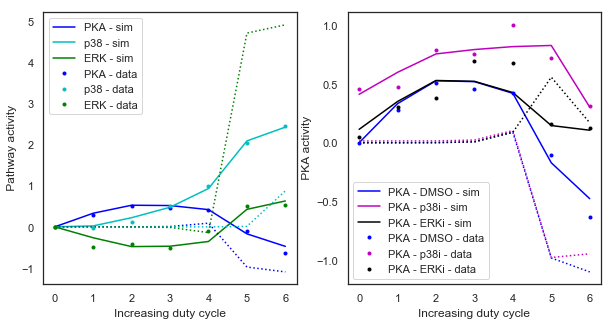

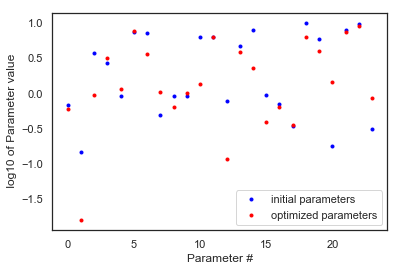

In [116]:
#checking on optimzation 

# ysim = main_fun(dutycycle, parameters_dmso_filter_opt)
# ysim2 = main_fun(dutycycle, parameters_dmso_filter[4,:])
# ysim3 = main_fun(dutycycle, parameters_dmso_filter_opt_nosigma)
bb=6
ysim4 = main_fun(dutycycle, parameters_dmso_filter_opt[bb,:])
ysim5 = main_fun(dutycycle, parameters_dmso_filter[bb,:])

fig, ax = plt.subplots(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ysim4[0:7], 'b', label = 'PKA - sim')
plt.plot(ysim4[7:14], 'c', label = 'p38 - sim')
plt.plot(ysim4[14:21], 'g', label = 'ERK - sim')

# plt.plot(ysim3[0:7], '--b')
# plt.plot(ysim3[7:14], '--c')
# plt.plot(ysim3[14:21], '--g')

plt.plot(ysim5[0:7], ':b')
plt.plot(ysim5[7:14], ':c')
plt.plot(ysim5[14:21], ':g')

plt.plot(ydata[0:7], '.b',  label = 'PKA - data')
plt.plot(ydata[7:14], '.c', label = 'p38 - data')
plt.plot(ydata[14:21], '.g', label = 'ERK - data')
plt.xlabel('Increasing duty cycle')
plt.ylabel(' Pathway activity')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ysim4[0:7], 'b',label = 'PKA - DMSO - sim')
plt.plot(ysim4[21:28], 'm', label = 'PKA - p38i - sim')
plt.plot(ysim4[28:35], color = 'k', label = 'PKA - ERKi - sim')


# plt.plot(ysim3[0:7], '--b')
# plt.plot(ysim3[21:28], '--m')
# plt.plot(ysim3[28:35],  '--k')


plt.plot(ysim5[0:7], ':b')
plt.plot(ysim5[21:28], ':m')
plt.plot(ysim5[28:35],  ':k')

plt.plot(ydata[0:7], '.b', label = 'PKA - DMSO - data')
plt.plot(ydata[21:28], '.m', label = 'PKA - p38i - data')
plt.plot(ydata[28:35], '.k', label = 'PKA - ERKi - data')
plt.xlabel('Increasing duty cycle')
plt.ylabel(' PKA activity')
plt.legend(loc = 'best')
plt.show()


plt.plot(np.log10(parameters_dmso_filter[bb,:]),'.b', label = 'initial parameters')
plt.plot(np.log10(parameters_dmso_filter_opt[bb,:]),'.r' ,label = 'optimized parameters')
# plt.plot(np.log10(parameters_dmso_filter_opt_nosigma),'.g' ,label = 'optimized parameters-nosgima')
plt.xlabel('Parameter #')
plt.ylabel(' log10 of Parameter value')
plt.legend(loc = 'best')
plt.show()



In [2]:
##load optimized parameters

parameters_dmso_filter_opt = np.genfromtxt("d:\parameters_ODEsim_DMSO_run_dutycycle_filter_opt.csv", delimiter = ',')


<input>:3: DeprecationWarning: invalid escape sequence \p
<ipython-input-2-ec0994347e40>:3: DeprecationWarning: invalid escape sequence \p
  parameters_dmso_filter_opt = np.genfromtxt("d:\parameters_ODEsim_DMSO_run_dutycycle_filter_opt.csv", delimiter = ',')


c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:204: RuntimeWarning: divide by zero encountered in log2


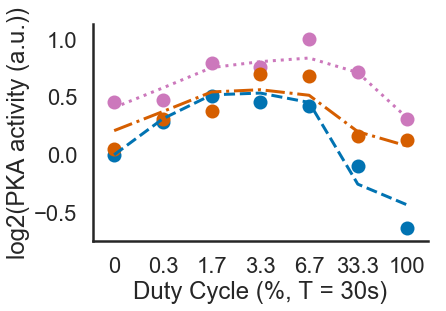

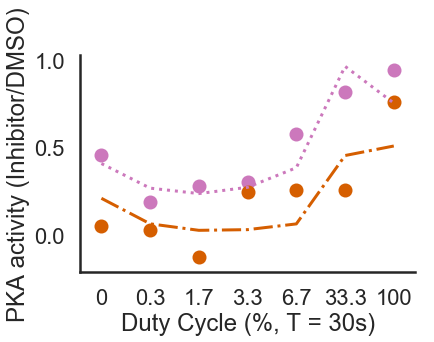

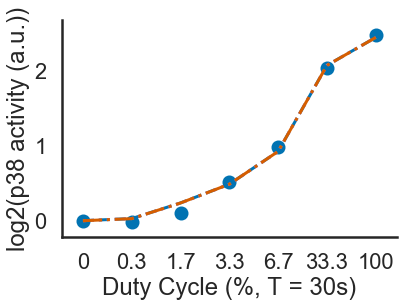

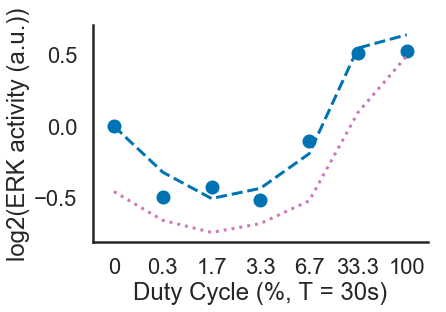

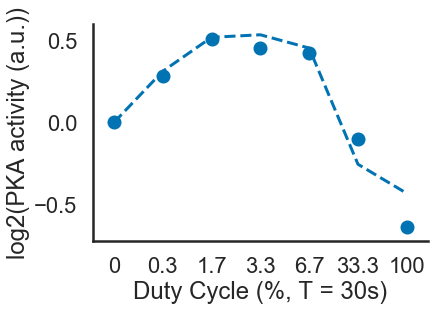

In [4]:
##create figure for paper

colors = np.array(sns.color_palette('colorblind'))
sns.set(style = 'white', context = 'poster', font = 'Arial', palette = 'Set2')
bb = 15
yall=  main_fun2(dutycycle, *parameters_dmso_filter_opt[bb,:])


fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall[0:7], color = colors[0], linestyle ='--')
plt.scatter(np.arange(0,7), ydata[0:7], color = colors[0], label = 'DMSO')

plt.plot(np.arange(0,7), (yall[21:28]), color = colors[4], linestyle =':')
plt.scatter(np.arange(0,7), ydata[21:28], color = colors[4], label = 'p38 inhibition')

plt.plot(np.arange(0,7), (yall[28:35]), color = colors[3], linestyle ='-.')
plt.scatter(np.arange(0,7), ydata[28:35], color = colors[3], label = 'ERK inhibition')

plt.ylabel('log2(PKA activity (a.u.))')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_PKAall.eps", type = 'eps')

plt.show()

fig, ax = plt.subplots()
ycomp_sim_p38= yall[21:28]-yall[0:7]
ycomp_sim_ERK= yall[28:35]-yall[0:7]
ycomp_data_p38= ydata[21:28]-ydata[0:7]
ycomp_data_ERK= ydata[28:35]-ydata[0:7]

plt.plot(np.arange(0,7), ycomp_sim_p38, color = colors[4], linestyle =':')
plt.plot(np.arange(0,7), ycomp_sim_ERK, color = colors[3], linestyle ='-.')

plt.scatter(np.arange(0,7), ycomp_data_p38, color = colors[4])
plt.scatter(np.arange(0,7), ycomp_data_ERK, color = colors[3])

plt.ylabel('PKA activity (Inhibitor/DMSO)')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()

plt.savefig(folder_fig + "MODEL_PARAM15_dif.eps", type = 'eps')
plt.show()


fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall[7:14], color = colors[0], linestyle ='--')
plt.scatter(np.arange(0,7), ydata[7:14], color = colors[0], label = 'DMSO')

plt.plot(np.arange(0,7), (yall[35:42]), color = colors[4], linestyle =':')
# plt.scatter(np.arange(0,7), ydata[21:28], color = colors[4], label = 'p38 inhibition')

plt.plot(np.arange(0,7), (yall[42:49]), color = colors[3], linestyle ='-.')
# plt.scatter(np.arange(0,7), ydata[28:35], color = colors[3], label = 'ERK inhibition')


plt.ylabel('log2(p38 activity (a.u.))')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_P38.eps", type = 'eps')
plt.show()

fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall[14:21], color = colors[0], linestyle ='--')
plt.scatter(np.arange(0,7), ydata[14:21], color = colors[0], label = 'DMSO')


plt.plot(np.arange(0,7), (yall[49:56]), color = colors[4], linestyle =':')
# plt.scatter(np.arange(0,7), ydata[21:28], color = colors[4], label = 'p38 inhibition')

plt.plot(np.arange(0,7), (yall[56:63]), color = colors[3], linestyle ='-.')
# plt.scatter(np.arange(0,7), ydata[28:35], color = colors[3], label = 'ERK inhibition')



plt.ylabel('log2(ERK activity (a.u.))')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_ERK.eps", type = 'eps')
plt.show()

fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall[0:7], color = colors[0], linestyle ='--')
plt.scatter(np.arange(0,7), ydata[0:7], color = colors[0], label = 'DMSO')
plt.ylabel('log2(PKA activity (a.u.))')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_PKA.eps", type = 'eps')
plt.show()

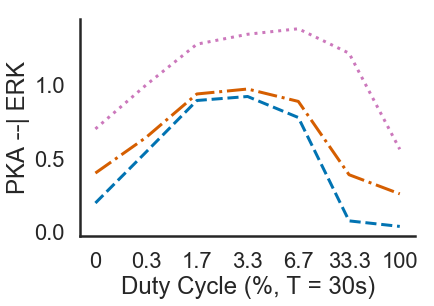

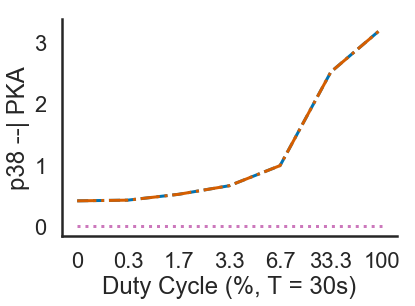

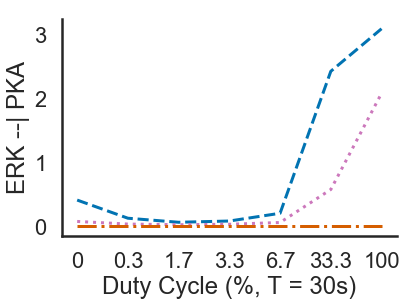

In [39]:
yall2=  main_fun3(dutycycle, *parameters_dmso_filter_opt[bb,:])

fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall2[0:7], color = colors[0], linestyle ='--', label = 'DMSO')

plt.plot(np.arange(0,7), (yall2[21:28]), color = colors[4], linestyle =':', label = 'p38 inhibition')

plt.plot(np.arange(0,7), (yall2[28:35]), color = colors[3], linestyle ='-.', label = 'ERK inhibition')

# plt.title('PKA inhibition on ERK')
# plt.legend()
plt.ylabel('PKA --| ERK')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_PKAi-ERK.eps", type = 'eps')
plt.show()


fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall2[7:14], color = colors[0], linestyle ='--', label = 'DMSO')

plt.plot(np.arange(0,7), (yall2[35:42]), color = colors[4], linestyle =':', label = 'p38 inhibition')

plt.plot(np.arange(0,7), (yall2[42:49]), color = colors[3], linestyle ='-.', label = 'ERK inhibition')

# plt.title('PKA inhibition on ERK')
# plt.legend()
plt.ylabel('p38 --| PKA')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_p38i-PKA.eps", type = 'eps')
plt.show()


fig, ax = plt.subplots()
plt.plot(np.arange(0,7), yall2[14:21], color = colors[0], linestyle ='--', label = 'DMSO')

plt.plot(np.arange(0,7), (yall2[49:56]), color = colors[4], linestyle =':', label = 'p38 inhibition')

plt.plot(np.arange(0,7), (yall2[56:63]), color = colors[3], linestyle ='-.', label = 'ERK inhibition')

# plt.title('PKA inhibition on ERK')
# plt.legend()
plt.ylabel('ERK --| PKA')
plt.xticks(np.arange(0,7))
ax.set_xticklabels([0, 0.3, 1.7, 3.3, 6.7, 33.3, 100])
plt.xlabel('Duty Cycle (%, T = 30s)')
# plt.legend(loc ='best')
sns.despine()
plt.savefig(folder_fig + "MODEL_PARAM15_ERKi-PKA.eps", type = 'eps')
plt.show()

In [107]:
# distance = np.empty(len(parameters_dmso_filter))
# for ii in np.arange(len(parameters_dmso_filter)):
#     ysimopt = main_fun(dutycycle, parameters_dmso_filter_opt[ii,:])
#     distance[ii] = sum((ydata - ysimopt)**2)
print(distance)
np.argsort(distance)

[ 1.05692859  2.69741424  0.96670331  0.93008387  0.79517956 21.93449751
  0.39305377  0.39066336  0.54671516  1.89283076  2.37605708  0.84244762
  0.30098384  0.92572789  5.05201831  0.31588961  0.75864599  0.40233052
  1.78073189  4.74398562  0.63435758  0.39488227  0.43685975  1.81377606
  0.99429521]


array([12, 15,  7,  6, 21, 17, 22,  8, 20, 16,  4, 11, 13,  3,  2, 24,  0,
       18, 23,  9, 10,  1, 19, 14,  5], dtype=int64)

In [65]:
start = timeit.default_timer()
# kwargs = {"maxfev": 10}
bounds=(0.01, 10)
method = 'trf'
parameters_dmso_filter_opt = np.empty((len(parameters_dmso_filter),24))

# for ii in np.arange(0,2):
for ii in np.arange(len(parameters_dmso_filter)):
    parameters_dmso_filter_opt[ii], matcov = curve_fit(f=main_fun, xdata=dutycycle, ydata=ydata, method = method, p0 = parameters_dmso_filter[ii,:],bounds = bounds)
    
stop = timeit.default_timer()
print('Time: ', stop - start)

# np.savetxt("d:\parameters_ODEsim_DMSO_run_dutycycle_filter_opt.csv", parameters_dmso_filter_opt, delimiter=",")
# np.savetxt("d:\parameters_ODEsim_DMSO_run_dutycycle_filter.csv", parameters_dmso_filter, delimiter=",")

<input>:14: DeprecationWarning: invalid escape sequence \p
<ipython-input-65-1019268e2dbd>:14: DeprecationWarning: invalid escape sequence \p
  np.savetxt("d:\parameters_ODEsim_DMSO_run_dutycycle_filter_opt.csv", parameters_dmso_filter_opt, delimiter=",")
c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
c:\users\jfonseca\appdata\local\programs\python\python36\lib\site-packages\scipy\integrate\_ivp\rk.py:144: RuntimeWarning: invalid value encountered in maximum
  scale = atol + np.maximum(np.abs(y), np.abs(y_new)) * rtol


Time:  29701.221304133054


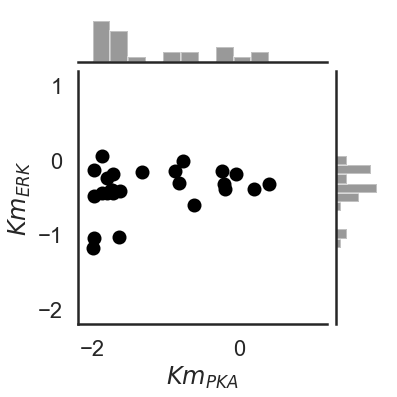

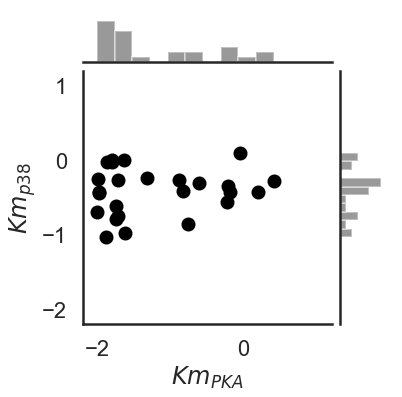

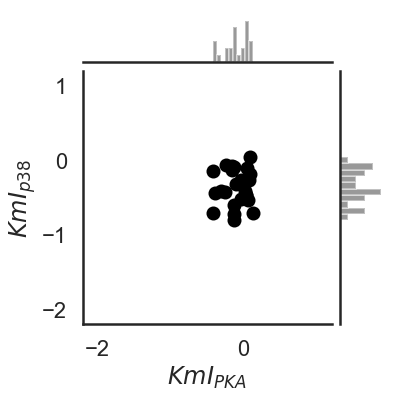

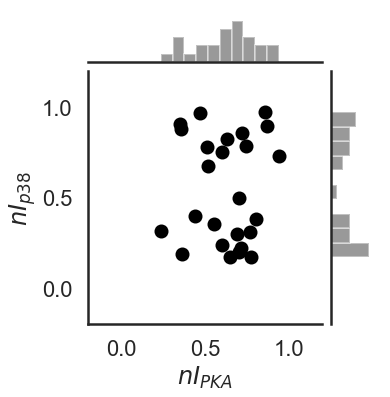

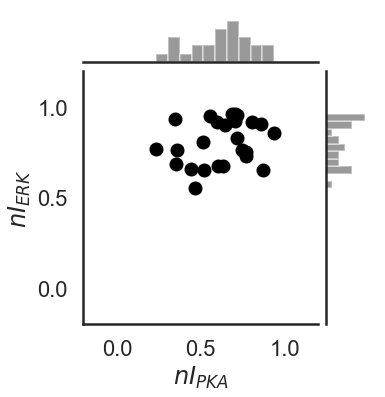

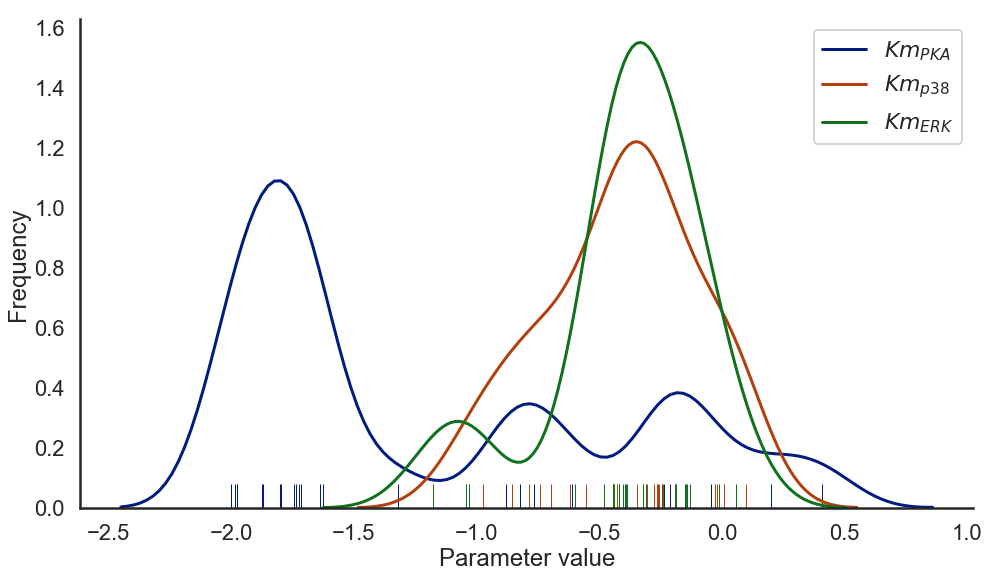

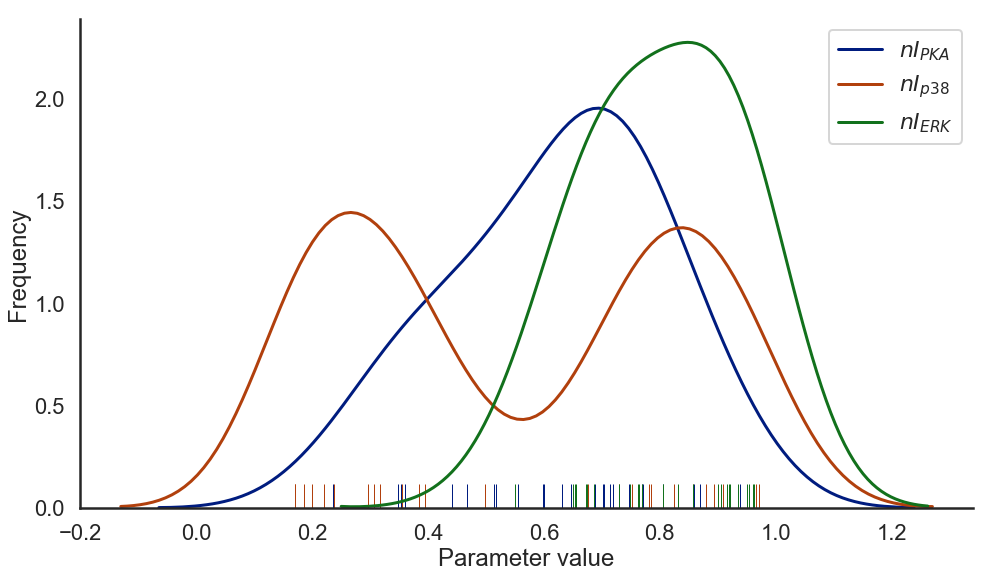

In [157]:
g= sns.jointplot(data=df_test, x= 'km_PKAa', y='km_ERKa',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$Km_{PKA}$", "$Km_{ERK}$")
plt.savefig(folder_fig + 'KM_PKAvsKM_ERK.eps', type = 'eps', dpi = 300)
plt.show()

g= sns.jointplot(data=df_test, x= 'km_PKAa', y='km_p38a',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$Km_{PKA}$", "$Km_{p38}$")
plt.savefig(folder_fig + 'KM_PKAvsKM_p38.eps', type = 'eps', dpi = 300)
plt.show()

g= sns.jointplot(data=df_test, x= 'kmI_PKAa', y='kmI_p38a',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$KmI_{PKA}$", "$KmI_{p38}$")
plt.savefig(folder_fig + 'KMI_PKAvsKMI_p38.eps', type = 'eps', dpi = 300)
plt.show()

g= sns.jointplot(data=df_test, x= 'hillI_PKAa', y='hillI_p38a',
                 xlim=[-0.2, 1.2], ylim = [-0.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$nI_{PKA}$", "$nI_{p38}$")
plt.savefig(folder_fig + 'hillI_PKAvshillI_p38.eps', type = 'eps', dpi = 300)
plt.show()


g= sns.jointplot(data=df_test, x= 'hillI_PKAa', y='hillI_ERKa',
                 xlim=[-0.2, 1.2], ylim = [-0.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$nI_{PKA}$", "$nI_{ERK}$")
plt.savefig(folder_fig + 'hillI_PKAvshillI_ERK.eps', type = 'eps', dpi = 300)
plt.show()


fig, ax = plt.subplots(figsize = [16, 9])
sns.distplot(df_test['km_PKAa'], label ="$Km_{PKA}$", hist=False, rug=True , kde_kws={'bw':.15})
sns.distplot(df_test['km_p38a'], label ="$Km_{p38}$", hist=False, rug=True , kde_kws={'bw':.15})
sns.distplot(df_test['km_ERKa'], label ="$Km_{ERK}$", hist=False, rug=True, kde_kws={'bw':.15})
sns.despine()
plt.legend()
plt.xlabel('Parameter value')
plt.ylabel('Frequency')
plt.savefig(folder_fig + 'km_distributions.eps', type = 'eps', dpi = 300)
plt.show()

fig, ax = plt.subplots(figsize = [16, 9])
sns.set_palette('dark')
sns.distplot(df_test['hillI_PKAa'], label ="$nI_{PKA}$", hist=False, rug=True , kde = True,  bins = 10, kde_kws={'bw':.1})
sns.distplot(df_test['hillI_p38a'], label ="$nI_{p38}$", hist=False, rug=True ,  kde = True,  bins = 10,kde_kws={'bw':.1})
sns.distplot(df_test['hillI_ERKa'], label ="$nI_{ERK}$", hist=False, rug=True,  kde = True,  bins = 10,kde_kws={'bw':.1})
sns.despine()
plt.legend()
plt.xlabel('Parameter value')
plt.ylabel('Frequency')
plt.savefig(folder_fig + 'hillI_distributions.eps', type = 'eps', dpi = 300)
plt.show()

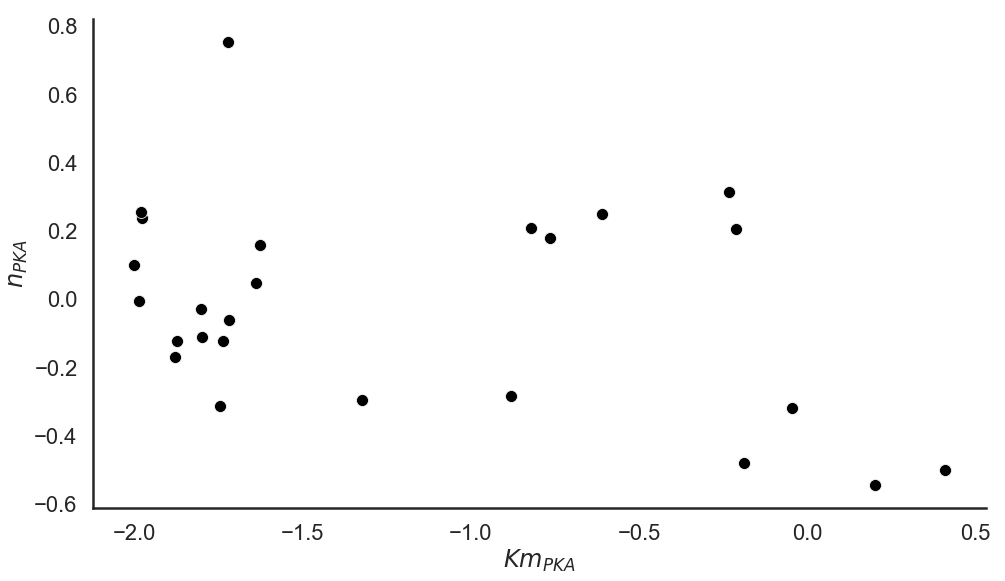

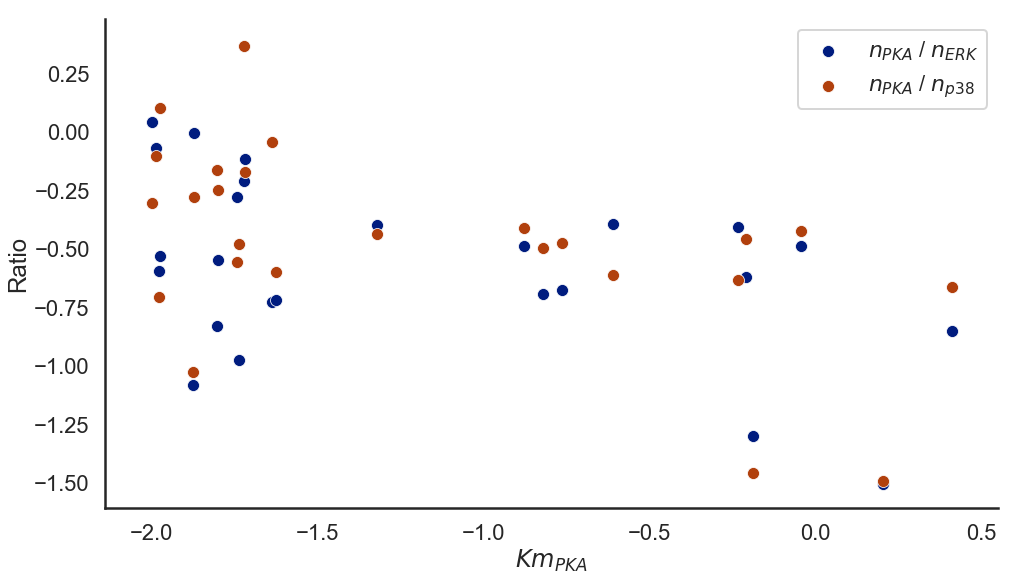

In [158]:
fig, ax = plt.subplots(figsize = [16, 9])
sns.scatterplot(data=df_test, x= 'km_PKAa', y='hill_PKAa', color ='k')
plt.xlabel("$Km_{PKA}$")
plt.ylabel('$n_{PKA}$')

sns.despine()
plt.savefig(folder_fig + 'kmPKA_vs_hillPKA.eps', type = 'eps', dpi = 300)
plt.show()

df_test['ratio'] = df_test['hill_PKAa']-df_test['hill_ERKa']
df_test['ratio2'] = df_test['hill_PKAa']-df_test['hill_p38a']

fig, ax = plt.subplots(figsize = [16, 9])
sns.scatterplot(data=df_test, x= 'km_PKAa', y='ratio', label = "$n_{PKA}$ / $n_{ERK}$")
sns.scatterplot(data=df_test, x= 'km_PKAa', y='ratio2', label = "$n_{PKA}$ / $n_{p38}$")
plt.xlabel("$Km_{PKA}$")
plt.ylabel('Ratio')
plt.legend()
sns.despine()
plt.savefig(folder_fig + 'kmPKA_vs_ratio_hill.eps', type = 'eps', dpi = 300)
plt.show()

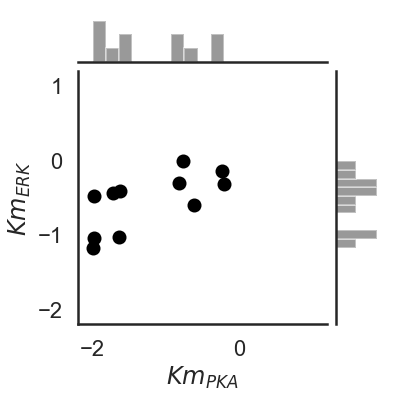

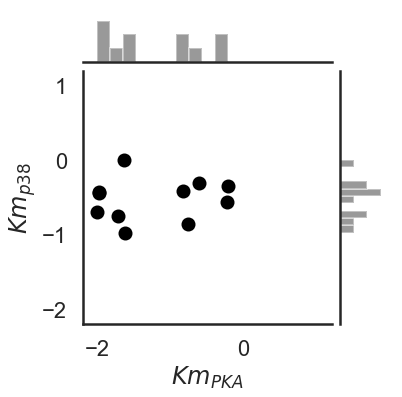

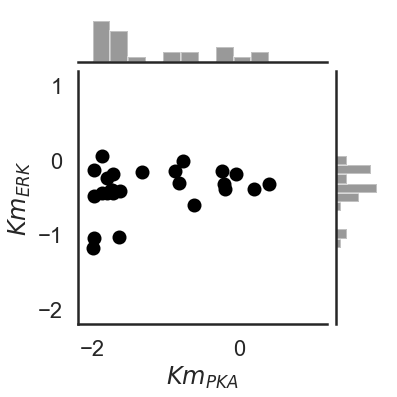

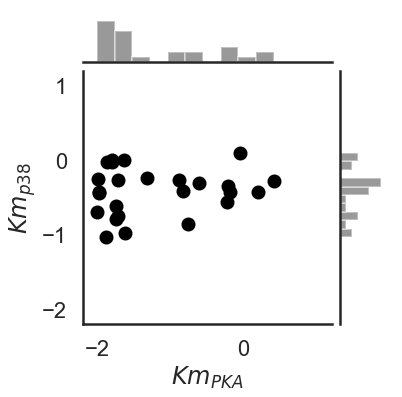

In [168]:
df_test2 = df_test[df_test['hill_PKAa']>(-0)]


g= sns.jointplot(data=df_test2, x= 'km_PKAa', y='km_ERKa',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$Km_{PKA}$", "$Km_{ERK}$")
plt.savefig(folder_fig + 'KM_PKAvsKM_ERK_nolown_PKA.eps', type = 'eps', dpi = 300)
plt.show()

g= sns.jointplot(data=df_test2, x= 'km_PKAa', y='km_p38a',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$Km_{PKA}$", "$Km_{p38}$")
plt.savefig(folder_fig + 'KM_PKAvsKM_p38_nolown_PKA.eps', type = 'eps', dpi = 300)
plt.show()

g= sns.jointplot(data=df_test, x= 'km_PKAa', y='km_ERKa',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$Km_{PKA}$", "$Km_{ERK}$")
plt.savefig(folder_fig + 'KM_PKAvsKM_ERK.eps', type = 'eps', dpi = 300)
plt.show()

g= sns.jointplot(data=df_test, x= 'km_PKAa', y='km_p38a',
                 xlim=[-2.2, 1.2], ylim = [-2.2,1.2], color = 'k', marginal_kws=dict(bins=10)).set_axis_labels("$Km_{PKA}$", "$Km_{p38}$")
plt.savefig(folder_fig + 'KM_PKAvsKM_p38.eps', type = 'eps', dpi = 300)
plt.show()


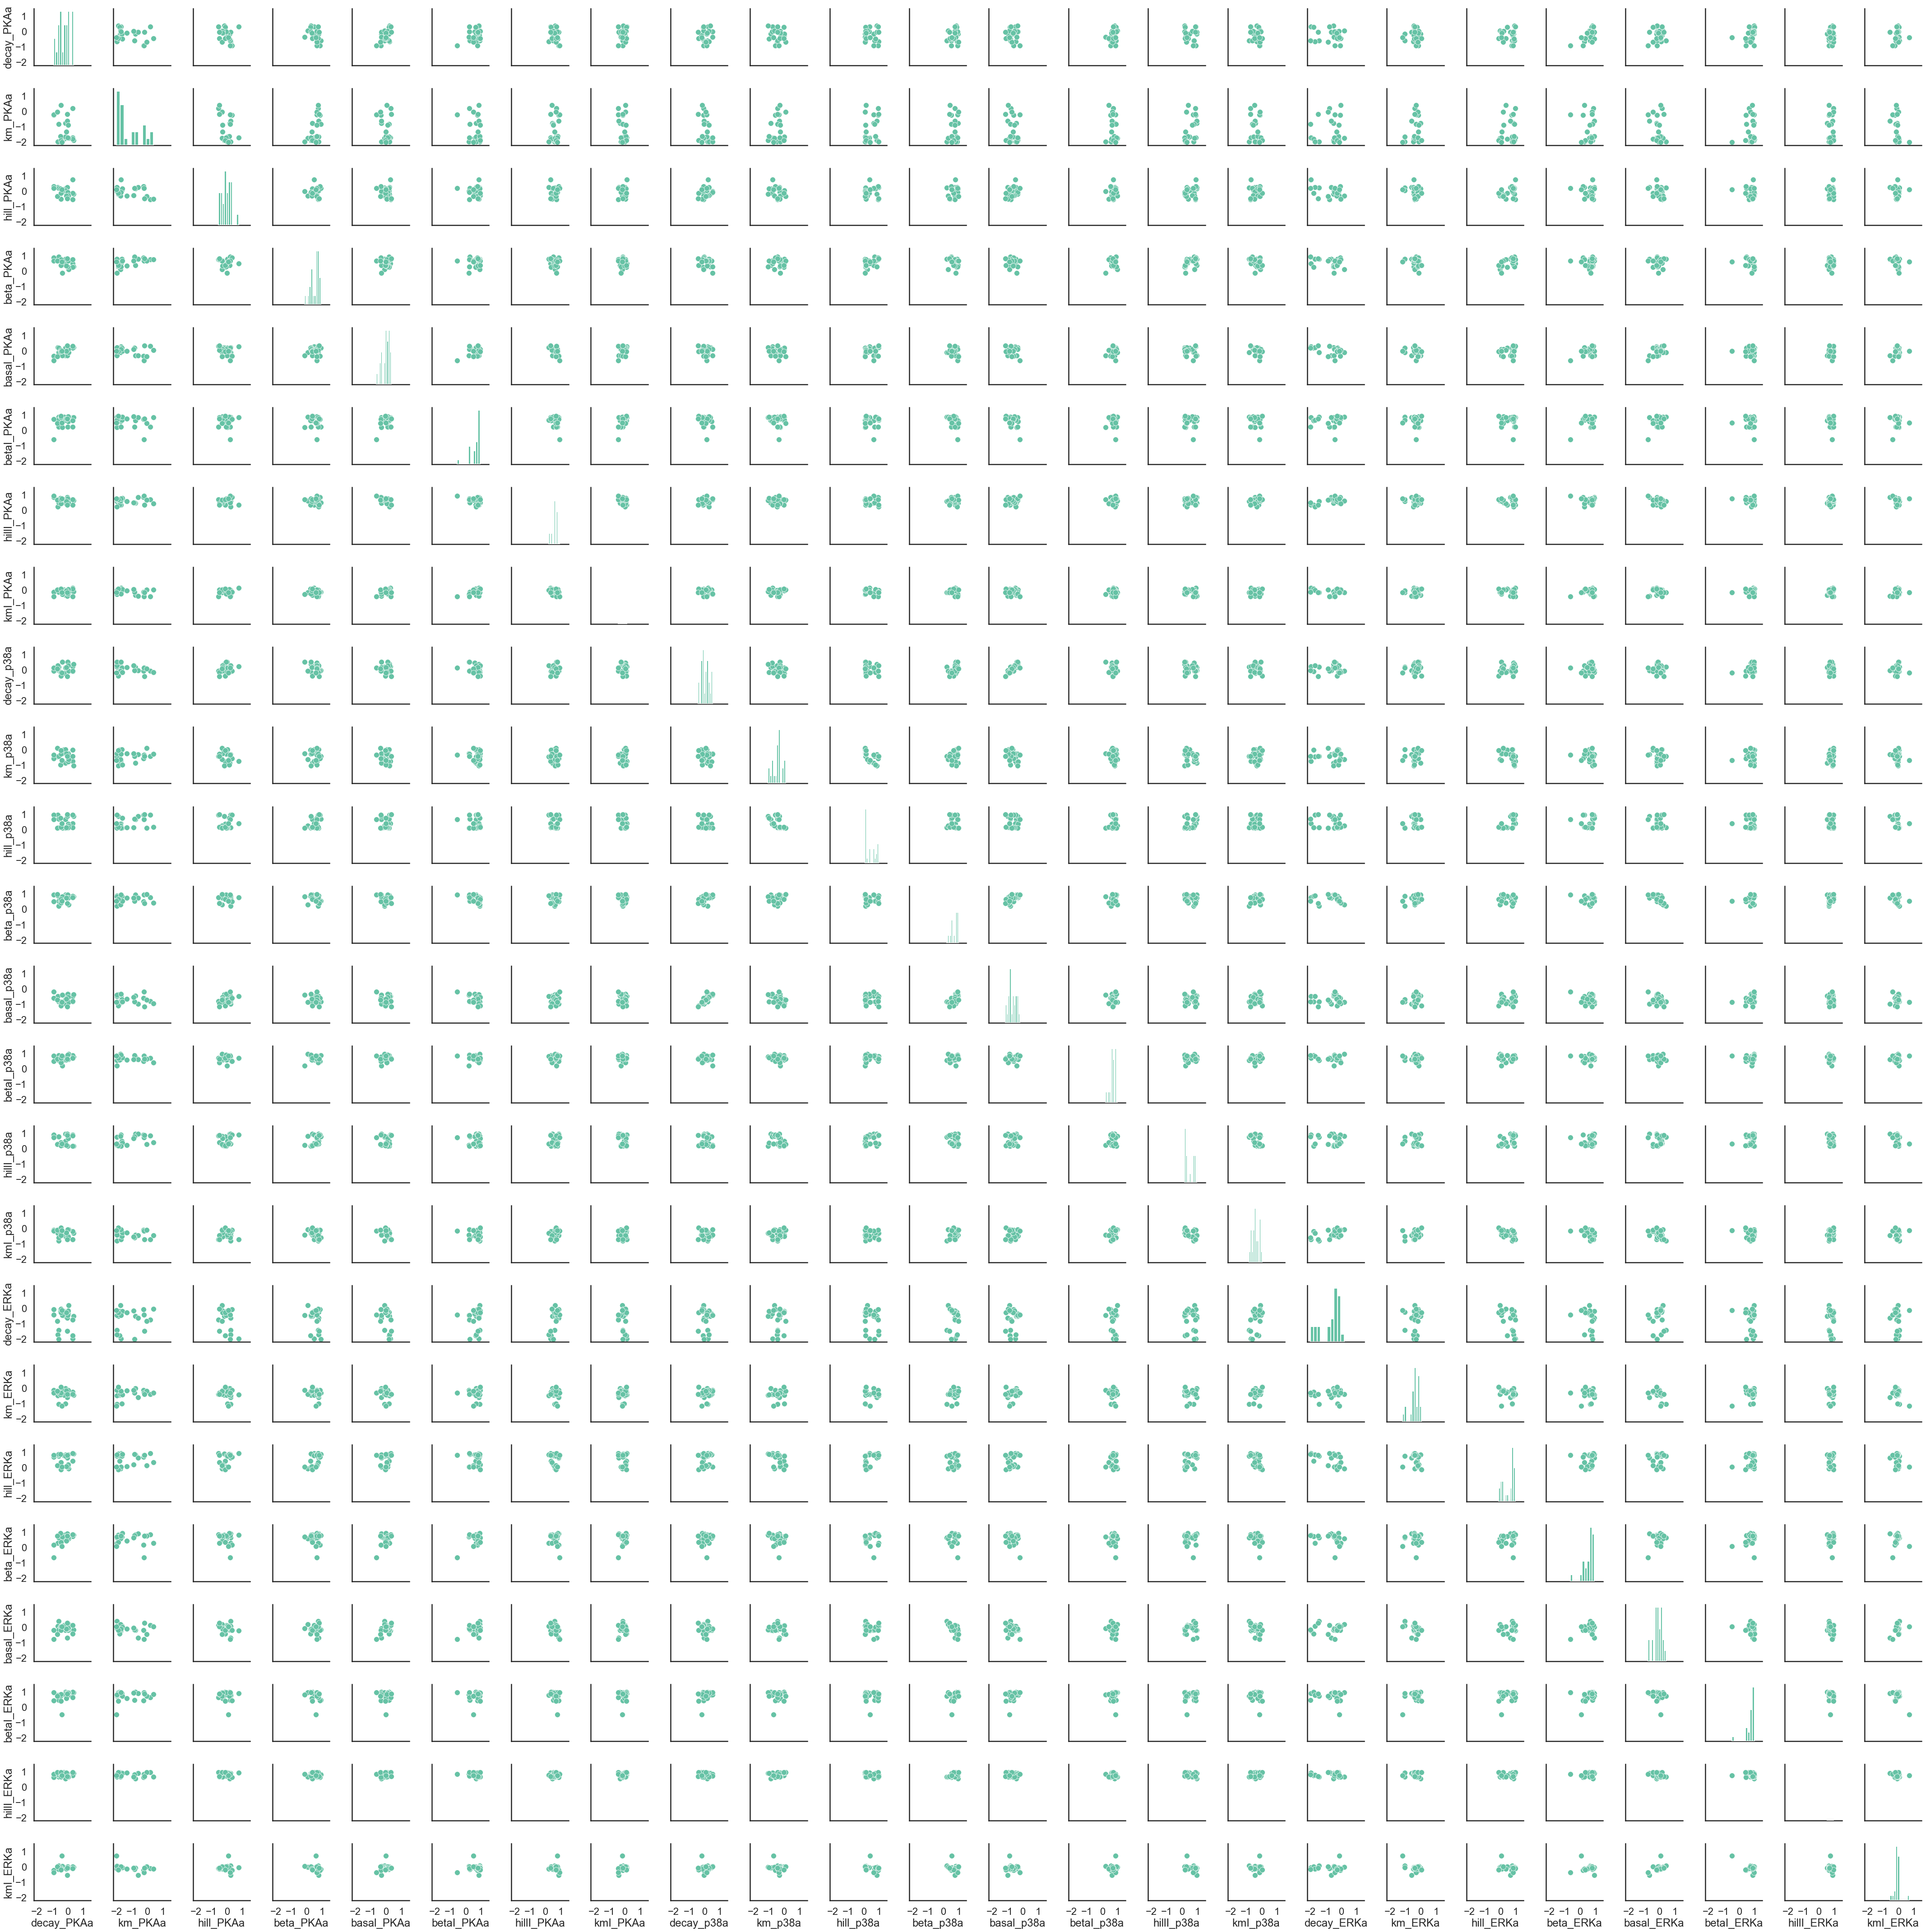

In [54]:
df_test = pd.DataFrame(data = np.log10(parameters_dmso_filter_opt),
                       columns=('decay_PKAa', 'km_PKAa', 'hill_PKAa', 'beta_PKAa', 'basal_PKAa', 'betaI_PKAa', 'hillI_PKAa', 'kmI_PKAa', 
         'decay_p38a', 'km_p38a', 'hill_p38a', 'beta_p38a', 'basal_p38a', 'betaI_p38a', 'hillI_p38a', 'kmI_p38a',
         'decay_ERKa', 'km_ERKa', 'hill_ERKa', 'beta_ERKa', 'basal_ERKa', 'betaI_ERKa', 'hillI_ERKa', 'kmI_ERKa'))


g = sns.pairplot(df_test)

axes = g.axes

for ii in np.arange(axes.shape[0]):
    for jj in np.arange(axes.shape[1]):
        axes[ii,jj].set_ylim(-2.2, 1.5)
        axes[ii,jj].set_xlim(-2.2, 1.5)
        axes[ii,jj].set_yticks([-2, -1, 0, 1])
        axes[ii,jj].set_xticks([-2, -1, 0, 1])
        

plt.savefig(folder_fig + 'parameter_distribution_v2.eps', type = 'eps', dpi = 300)
plt.show()